Loaded Shruti for Kattai 0_75 (246.94 Hz)
Loaded Shruti for Kattai 1 (261.63 Hz)
Loaded Shruti for Kattai 1_5 (277.18 Hz)
Loaded Shruti for Kattai 2 (293.66 Hz)
Loaded Shruti for Kattai 2_5 (311.13 Hz)
Loaded Shruti for Kattai 3 (329.63 Hz)
Loaded Shruti for Kattai 4 (349.23 Hz)
Loaded Shruti for Kattai 4_5 (369.99 Hz)
Loaded Shruti for Kattai 5 (392.0 Hz)
Loaded Shruti for Kattai 5_5 (415.3 Hz)
Loaded Shruti for Kattai 6 (440.0 Hz)
Loaded Shruti for Kattai 6_5 (466.16 Hz)
Loaded Shruti for Kattai 7 (493.88 Hz)
Distance with 246.94 Hz Shruti: 0.6621
Distance with 261.63 Hz Shruti: 0.7234
Distance with 277.18 Hz Shruti: 0.7395
Distance with 293.66 Hz Shruti: 0.6732
Distance with 311.13 Hz Shruti: 0.5577
Distance with 329.63 Hz Shruti: 0.4738
Distance with 349.23 Hz Shruti: 0.8163
Distance with 369.99 Hz Shruti: 0.8116
Distance with 392.0 Hz Shruti: 0.8094
Distance with 415.3 Hz Shruti: 0.8088
Distance with 440.0 Hz Shruti: 0.8131
Distance with 466.16 Hz Shruti: 0.6813
Distance with 493.

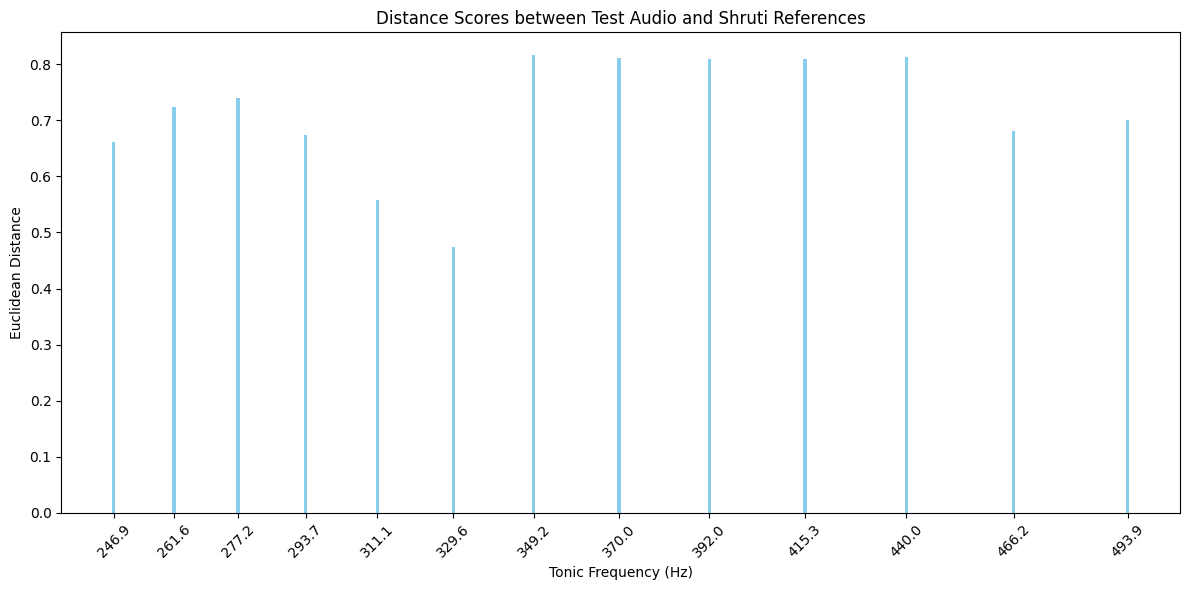

Predicted Tonic Note: E

Identified Swaras:
Sa_high: 390
Sa: 5608
Ma1: 99
Ga1: 243
Ni2: 46
Ri2: 257
Ma2: 109
Ri1: 39
Dha1: 254
Ga2: 117
Pa: 292
Ni1: 280
Dha2: 69


In [2]:
# predict_tonic.py

import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from kattai_freqs import kattai_freqs


def load_audio(file_path, sr=22050):
    """
    Load an audio file.

    Parameters:
    - file_path: Path to the audio file.
    - sr: Sampling rate.

    Returns:
    - y: Audio time series.
    - sr: Sampling rate.
    """
    y, sr = librosa.load(file_path, sr=sr, mono=True)
    return y, sr


def extract_pitch_histogram(y, sr, bins=128, hist_range=(0, 128)):
    """
    Extract a pitch histogram using HPSS and YIN algorithm.

    Parameters:
    - y: Audio time series.
    - sr: Sampling rate.
    - bins: Number of histogram bins.
    - hist_range: The lower and upper range of the bins.

    Returns:
    - histogram: Normalized pitch histogram.
    """
    # Separate harmonic and percussive components
    y_harmonic, y_percussive = librosa.effects.hpss(y)

    # Use YIN for fundamental frequency estimation
    f0 = librosa.yin(y_harmonic, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0 = f0[f0 > 0]  # Remove unvoiced frames

    if len(f0) == 0:
        return np.zeros(bins)

    # Convert frequencies to MIDI notes
    midi_notes = librosa.hz_to_midi(f0)
    histogram, _ = np.histogram(midi_notes, bins=bins, range=hist_range)
    histogram = histogram.astype(float)
    histogram /= np.sum(histogram)  # Normalize

    return histogram


def load_shruthis(shruthis_dir):
    """
    Load and process tanpura (Shruti) reference audios.

    Parameters:
    - shruthis_dir: Directory containing shruti subdirectories.

    Returns:
    - shruti_features: Dictionary mapping frequency to pitch histogram.
    """
    shruti_features = {}
    for kattai_str, freq in kattai_freqs.items():
        # Convert kattai key from float to string with underscore
        kattai_dir = os.path.join(shruthis_dir, f'kattai{kattai_str}')
        audio_file = os.path.join(kattai_dir, f'kattai{kattai_str}_audio_1.wav')

        if not os.path.exists(audio_file):
            print(f"Warning: {audio_file} does not exist. Skipping.")
            continue

        y, sr = load_audio(audio_file)
        histogram = extract_pitch_histogram(y, sr)
        shruti_features[freq] = histogram

        print(f"Loaded Shruti for Kattai {kattai_str} ({freq} Hz)")

    return shruti_features


def process_test_audio(test_audio_path, shruti_features):
    """
    Process the test audio and compute similarity with shruti references.

    Parameters:
    - test_audio_path: Path to the test audio file.
    - shruti_features: Dictionary mapping frequency to pitch histogram.

    Returns:
    - similarity_scores: Dictionary mapping frequency to similarity score.
    """
    y, sr = load_audio(test_audio_path)
    test_histogram = extract_pitch_histogram(y, sr)

    similarity_scores = {}
    for freq, shruti_hist in shruti_features.items():
        distance = euclidean(test_histogram, shruti_hist)
        similarity_scores[freq] = distance

        print(f"Distance with {freq} Hz Shruti: {distance:.4f}")

    return similarity_scores


def predict_tonic(similarity_scores):
    """
    Predict the tonic frequency based on similarity scores.

    Parameters:
    - similarity_scores: Dictionary mapping frequency to similarity score.

    Returns:
    - predicted_freq: Predicted tonic frequency.
    - sorted_scores: List of frequencies sorted by similarity.
    """
    sorted_scores = sorted(similarity_scores.items(), key=lambda item: item[1])
    predicted_freq = sorted_scores[0][0]
    return predicted_freq, sorted_scores


def plot_similarity(similarity_scores):
    """
    Plot similarity scores for visualization.

    Parameters:
    - similarity_scores: Dictionary mapping frequency to similarity score.
    """
    freqs = list(similarity_scores.keys())
    scores = list(similarity_scores.values())

    plt.figure(figsize=(12, 6))
    plt.bar(freqs, scores, color='skyblue')
    plt.xlabel('Tonic Frequency (Hz)')
    plt.ylabel('Euclidean Distance')
    plt.title('Distance Scores between Test Audio and Shruti References')
    plt.xticks(freqs, rotation=45)
    plt.tight_layout()
    plt.show()


def map_freq_to_swara(detected_freq, tonic_freq):
    """
    Map a detected frequency to the nearest swara based on the tonic frequency.

    Parameters:
    - detected_freq: Frequency to map.
    - tonic_freq: Identified tonic frequency.

    Returns:
    - swara: Identified swara.
    """
    swara_ratios = {
        'Sa': 1.00,
        'Ri1': 1.06,
        'Ri2': 1.12,
        'Ga1': 1.19,
        'Ga2': 1.26,
        'Ma1': 1.33,
        'Ma2': 1.41,
        'Pa': 1.50,
        'Dha1': 1.59,
        'Dha2': 1.68,
        'Ni1': 1.78,
        'Ni2': 1.89,
        'Sa_high': 2.00
    }

    swara_freqs = {swara: tonic_freq * ratio for swara, ratio in swara_ratios.items()}
    swara_names = list(swara_freqs.keys())
    swara_values = list(swara_freqs.values())

    index = np.argmin([abs(detected_freq - swara_freq) for swara_freq in swara_values])
    return swara_names[index]


def identify_swaras(y, sr, tonic_freq, frame_length=2048, hop_length=512):
    """
    Identify swaras in the audio based on the tonic frequency.

    Parameters:
    - y: Audio time series.
    - sr: Sampling rate.
    - tonic_freq: Identified tonic frequency.
    - frame_length: Number of samples per frame.
    - hop_length: Number of samples between frames.

    Returns:
    - swaras: List of identified swaras.
    """
    f0 = librosa.yin(y, fmin=tonic_freq * 0.5, fmax=tonic_freq * 2.0, frame_length=frame_length, hop_length=hop_length)
    f0 = f0[f0 > 0]

    swaras = [map_freq_to_swara(freq, tonic_freq) for freq in f0]
    return swaras


def main():
    # Paths
    shruthis_dir = 'shruthis'  # Directory containing shruthi subdirectories
    test_audio_path = 'audios/muthai_tharu.mp3'  # Test audio file

    if not os.path.exists(shruthis_dir):
        print(f"Error: {shruthis_dir} directory does not exist.")
        return

    if not os.path.exists(test_audio_path):
        print(f"Error: {test_audio_path} does not exist.")
        return

    # Step 1: Load Shruti References
    shruti_features = load_shruthis(shruthis_dir)

    if not shruti_features:
        print("Error: No Shruti references loaded. Exiting.")
        return

    # Step 2: Process Test Audio
    similarity_scores = process_test_audio(test_audio_path, shruti_features)

    # Step 3: Predict Tonic
    predicted_freq, sorted_scores = predict_tonic(similarity_scores)
    print(f"\nPredicted Tonic Frequency: {predicted_freq} Hz")

    # Step 4: Plot Similarity Scores
    plot_similarity(similarity_scores)

    # Step 5: Display in Musical Note
    note = librosa.hz_to_note(predicted_freq, octave=False)
    print(f"Predicted Tonic Note: {note}")

    # Step 6: Identify Swaras
    y, sr = load_audio(test_audio_path)
    swaras = identify_swaras(y, sr, predicted_freq)
    swara_counts = {}
    for swara in swaras:
        swara_counts[swara] = swara_counts.get(swara, 0) + 1

    print("\nIdentified Swaras:")
    for swara, count in swara_counts.items():
        print(f"{swara}: {count}")


if __name__ == "__main__":
    main()
